In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_log_return_loaders, StockIndex
from utils.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [2]:
BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 320,
        "num_layers": 3,
        "dropout": 0.16234554872884044,
        "batch_size": 16,
        "lr": 0.001025807645705379
    },
    StockIndex.AAPL: {
        "hidden_dim": 480,
        "num_layers": 2,
        "dropout": 0.3143251016235965,
        "batch_size": 64,
        "lr": 0.00016388823896781193
    },
    StockIndex.KO: {
        "hidden_dim": 416,
        "num_layers": 2,
        "dropout": 0.430297708579934,
        "batch_size": 64,
        "lr": 0.0023156709535714637
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 14,
        "encoded_dim": 8,
        "grid": 17,
        "k": 2,
        "lambda_reg": 1.2856933495455565e-05,
        "lamb_entropy": 1.2690516036569361,
        "lamb_l1": 1.0178703233437327,
        "lr": 0.005759900735645647
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 4,
        "encoded_dim": 4,
        "grid": 9,
        "k": 2,
        "lambda_reg": 2.7947832487959755e-05,
        "lamb_entropy": 0.41244736213499783,
        "lamb_l1": 1.5776285378778048,
        "lr": 0.00018069708122183257
    },
    StockIndex.KO: {
        "kan_hidden_dim": 7,
        "encoded_dim": 4,
        "grid": 11,
        "k": 3,
        "lambda_reg": 0.00017602791396212401,
        "lamb_entropy": 1.4591922326555635,
        "lamb_l1": 1.4591922326555635,
        "lr": 0.0001272136728401398
    }
}

## Training KAN -> LSTM for each stock ##

### NVIDIA ###

In [36]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

checkpoint directory created: ./kan_model
saving model version 0.0
Epoch 1: Train Loss = 0.001248 | Val Loss = 0.000688
Epoch 2: Train Loss = 0.001130 | Val Loss = 0.000710
Epoch 3: Train Loss = 0.001101 | Val Loss = 0.000685
Epoch 4: Train Loss = 0.001095 | Val Loss = 0.000711
Epoch 5: Train Loss = 0.001107 | Val Loss = 0.000819
Epoch 6: Train Loss = 0.001110 | Val Loss = 0.000696
Epoch 7: Train Loss = 0.001113 | Val Loss = 0.000688
Epoch 8: Train Loss = 0.001100 | Val Loss = 0.000686
Epoch 9: Train Loss = 0.001097 | Val Loss = 0.000700
Epoch 10: Train Loss = 0.001093 | Val Loss = 0.000704
Epoch 11: Train Loss = 0.001088 | Val Loss = 0.000686
Epoch 12: Train Loss = 0.001091 | Val Loss = 0.000703
Epoch 13: Train Loss = 0.001094 | Val Loss = 0.000687
Epoch 14: Train Loss = 0.001089 | Val Loss = 0.000687
Epoch 15: Train Loss = 0.001089 | Val Loss = 0.000693
Epoch 16: Train Loss = 0.001089 | Val Loss = 0.000685
Epoch 17: Train Loss = 0.001088 | Val Loss = 0.000684
Epoch 18: Train Loss = 0

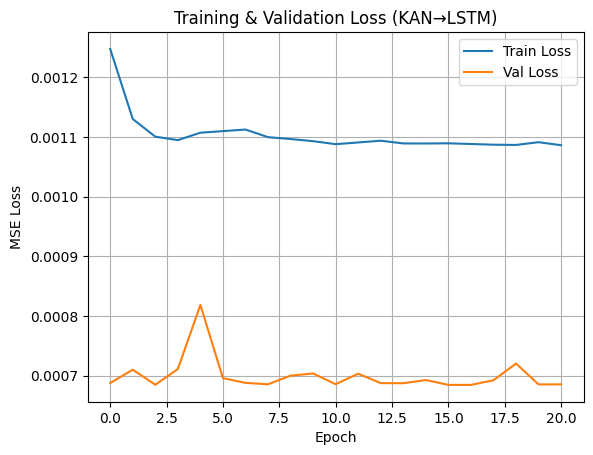

In [37]:
nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED,
    grid_range=[-0.3, 0.3],
    auto_save=True
).to(device)

nvda_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
    {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )

        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    nvda_encoder.eval()
    nvda_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = nvda_encoder(xb)
            preds = nvda_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.0024899915
Std of predicted return: 1.851656e-09
Mean actual return: 0.002643923
Std of actual return: 0.032575168
Test RMSE: 3.8670
Test MAE : 3.0029


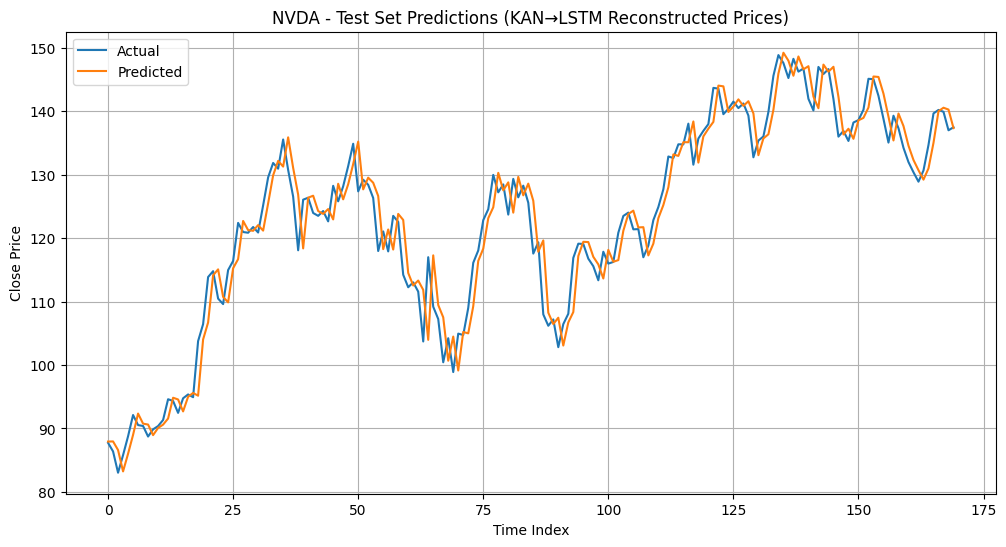

In [38]:
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)
        y_pred = nvda_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


### Apple ###

In [34]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.000574 | Val Loss = 0.000169
Epoch 2: Train Loss = 0.000430 | Val Loss = 0.000188
Epoch 3: Train Loss = 0.000433 | Val Loss = 0.000173
Epoch 4: Train Loss = 0.000424 | Val Loss = 0.000169
Epoch 5: Train Loss = 0.000427 | Val Loss = 0.000169
Epoch 6: Train Loss = 0.000422 | Val Loss = 0.000180
Epoch 7: Train Loss = 0.000425 | Val Loss = 0.000177
Epoch 8: Train Loss = 0.000422 | Val Loss = 0.000169
Epoch 9: Train Loss = 0.000428 | Val Loss = 0.000174
Epoch 10: Train Loss = 0.000427 | Val Loss = 0.000172
Epoch 11: Train Loss = 0.000423 | Val Loss = 0.000184
Epoch 12: Train Loss = 0.000422 | Val Loss = 0.000169
Epoch 13: Train Loss = 0.000422 | Val Loss = 0.000170
Epoch 14: Train Loss = 0.000422 | Val Loss = 0.000170
Epoch 15: Train Loss = 0.000420 | Val Loss = 0.000173
Epoch 16: Train Loss = 0.000429 | Val Loss = 0.000170
Epoch 17: Train Loss = 0.000424 | Val Loss = 0.000182
Epoch 18: Train Loss = 0.000437 | Val Loss = 0.000183
Epoch 19: Train Loss = 0.000426 | Val

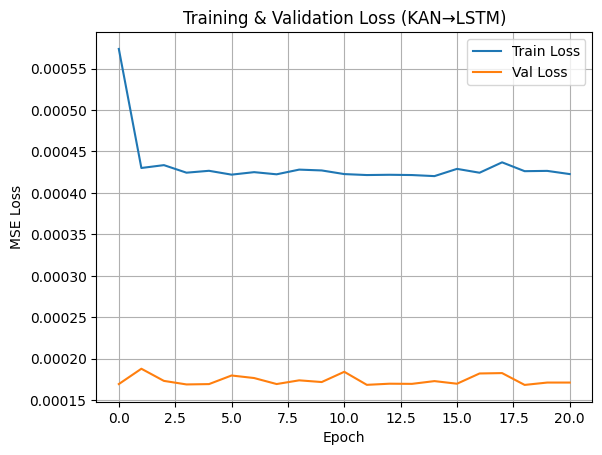

In [24]:
aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

aapl_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
    {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )

        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    aapl_encoder.eval()
    aapl_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = aapl_encoder(xb)
            preds = aapl_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.0012272327
Std of predicted return: 6.6412363e-06
Mean actual return: 0.002365659
Std of actual return: 0.014482381
Test RMSE: 3.0999
Test MAE : 2.2320


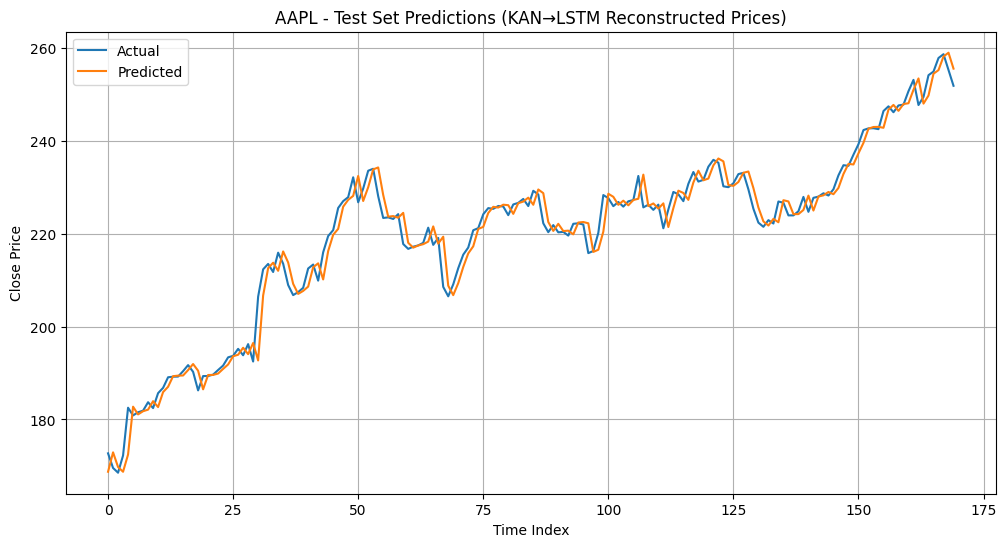

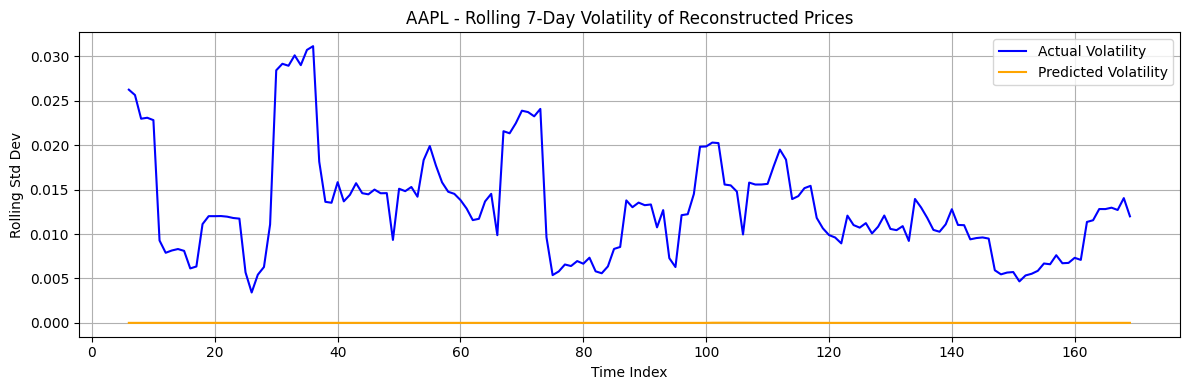

In [35]:
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)
        y_pred = aapl_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

import pandas as pd
# --- Rolling Volatility (Price Level) ---
def rolling_std(x, window=7):
    return pd.Series(x).rolling(window=window).std().to_numpy()

window = 7  # can tweak
rolling_true_vol = rolling_std(targets, window)
rolling_pred_vol = rolling_std(preds, window)

# --- Plot Volatility ---
plt.figure(figsize=(12, 4))
plt.plot(rolling_true_vol, label="Actual Volatility", color="blue")
plt.plot(rolling_pred_vol, label="Predicted Volatility", color="orange")
plt.title(f"{stock.value} - Rolling {window}-Day Volatility of Reconstructed Prices")
plt.xlabel("Time Index")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Coke ###

In [3]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.003099 | Val Loss = 0.000149
Epoch 2: Train Loss = 0.000199 | Val Loss = 0.000071
Epoch 3: Train Loss = 0.000178 | Val Loss = 0.000070
Epoch 4: Train Loss = 0.000178 | Val Loss = 0.000071
Epoch 5: Train Loss = 0.000176 | Val Loss = 0.000073
Epoch 6: Train Loss = 0.000179 | Val Loss = 0.000075
Epoch 7: Train Loss = 0.000178 | Val Loss = 0.000070
Epoch 8: Train Loss = 0.000180 | Val Loss = 0.000072
Epoch 9: Train Loss = 0.000178 | Val Loss = 0.000070
Epoch 10: Train Loss = 0.000176 | Val Loss = 0.000071
Epoch 11: Train Loss = 0.000176 | Val Loss = 0.000070
Epoch 12: Train Loss = 0.000176 | Val Loss = 0.000070
Epoch 13: Train Loss = 0.000176 | Val Loss = 0.000083
Epoch 14: Train Loss = 0.000179 | Val Loss = 0.000074
Epoch 15: Train Loss = 0.000179 | Val Loss = 0.000070
Epoch 16: Train Loss = 0.000178 | Val Loss = 0.000072
Epoch 17: Train Loss = 0.000178 | Val Loss = 0.000071
Epoch 18: Train Loss = 0.000176 | Val Loss = 0.000071
Epoch 19: Train Loss = 0.000177 | Val

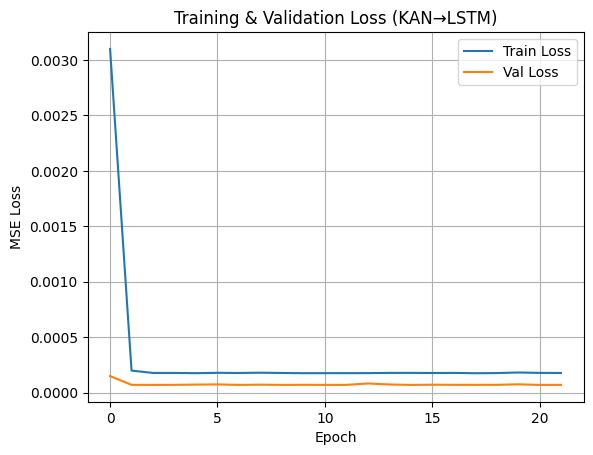

In [4]:
ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], kan_params['encoded_dim']],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

ko_lstm = LSTMRegressor(
    input_dim=kan_params['encoded_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
    {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )

        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    ko_encoder.eval()
    ko_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = ko_encoder(xb)
            preds = ko_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.0006014291
Std of predicted return: 2.9692264e-05
Mean actual return: 0.00015766906
Std of actual return: 0.00826914
Test RMSE: 0.5395
Test MAE : 0.4115


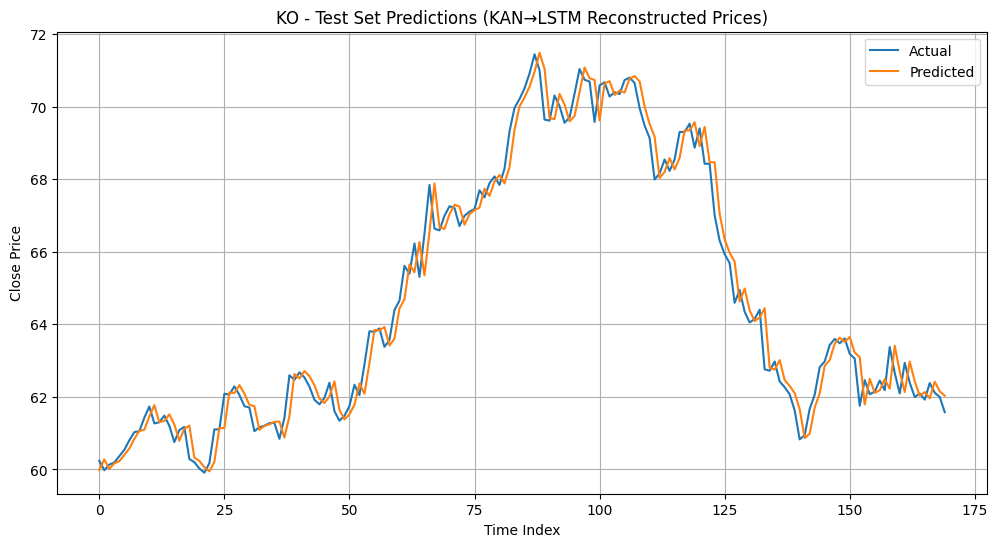

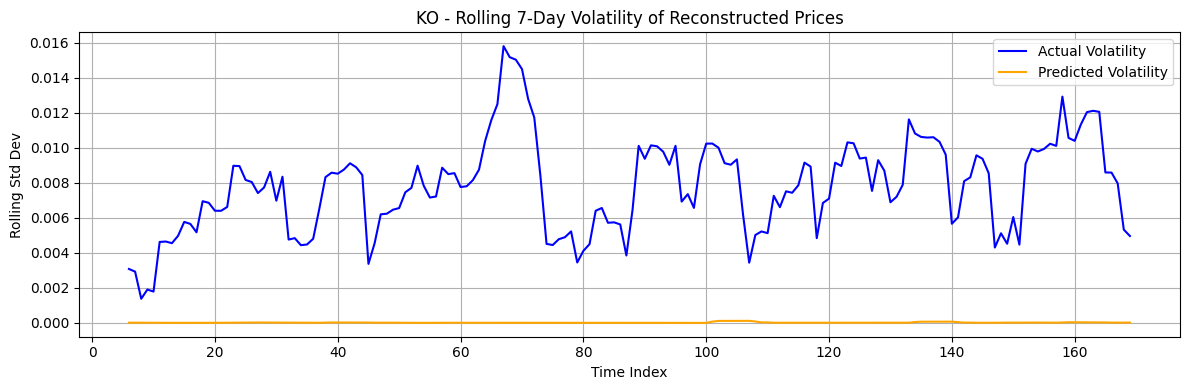

In [5]:
import pandas as pd
ko_encoder.eval()
ko_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)
        y_pred = ko_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


import pandas as pd
# --- Rolling Volatility (Price Level) ---
def rolling_std(x, window=7):
    return pd.Series(x).rolling(window=window).std().to_numpy()

window = 7  # can tweak
rolling_true_vol = rolling_std(targets, window)
rolling_pred_vol = rolling_std(preds, window)

# --- Plot Volatility ---
plt.figure(figsize=(12, 4))
plt.plot(rolling_true_vol, label="Actual Volatility", color="blue")
plt.plot(rolling_pred_vol, label="Predicted Volatility", color="orange")
plt.title(f"{stock.value} - Rolling {window}-Day Volatility of Reconstructed Prices")
plt.xlabel("Time Index")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
